In [1]:
import numpy as np
import ufl

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx import fem, io, nls
from dolfinx import plot
import dolfinx.fem.petsc
import dolfinx.nls.petsc
from dolfinx.mesh import create_box, CellType, create_rectangle, locate_entities
import pyvista
from ufl import (
    as_matrix,
    dx,
    dot,
    cos,
    sin,
    SpatialCoordinate,
    Identity,
    grad,
    ln,
    tr,
    det,
    variable,
    derivative,
    TestFunction,
    TrialFunction,
    inner,
    cross,
    inv,
    outer
)

In [2]:
pyvista.set_jupyter_backend('trame')

In [3]:
gmsh.initialize()
gmsh.model.add("beams")

p1 = gmsh.model.geo.addPoint(0, 0, 0)
p2 = gmsh.model.geo.addPoint(30, 0, 0)
p3 = gmsh.model.geo.addPoint(30, 5, 0)
p4 = gmsh.model.geo.addPoint(0, 5, 0)

p5 = gmsh.model.geo.addPoint(5, 2, 0)
p6 = gmsh.model.geo.addPoint(5, 3, 0)
p7 = gmsh.model.geo.addPoint(25, 3, 0)
p8 = gmsh.model.geo.addPoint(25, 2, 0)



l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

cl1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

l5 = gmsh.model.geo.addLine(p5, p6)
l6 = gmsh.model.geo.addLine(p6, p7)
l7 = gmsh.model.geo.addLine(p7, p8)
l8 = gmsh.model.geo.addLine(p8, p5)

cl2 = gmsh.model.geo.addCurveLoop([l5, l6, l7, l8])




surf1 = gmsh.model.geo.addPlaneSurface([cl1, cl2])

# for i in [surf1, surf2, surf3, surf4, surf5]: #[surf1 ,surf2, surf5]:#
#     gmsh.model.geo.mesh.setTransfiniteSurface(i)
#     gmsh.model.geo.mesh.setRecombine(2, i)
# gmsh.model.geo.mesh.setTransfiniteSurface(surf1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.5)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.5)
gmsh.model.addPhysicalGroup(2, [surf1], 1)
# gmsh.model.addPhysicalGroup(2, [surf2], 2)
# gmsh.model.addPhysicalGroup(2, [surf3], 3)
# gmsh.model.addPhysicalGroup(2, [surf4], 4)
# gmsh.model.addPhysicalGroup(2, [surf5], 5)

gmsh.model.setPhysicalName(2, 1, "left_clamp")
# gmsh.model.setPhysicalName(2, 2, "beam_bottom")
# gmsh.model.setPhysicalName(2, 3, "beam_middle")
# gmsh.model.setPhysicalName(2, 4, "beam_top")
# gmsh.model.setPhysicalName(2, 5, "right_clamp")

gmsh.model.geo.synchronize()

# 生成网格
gmsh.model.mesh.generate(2)
# #
# gmsh.fltk.run()

# # 保存
# gmsh.write("dumbbell_structured.msh")

# gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000349958s, CPU 0.000366s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.008778s, CPU 0.008425s)
Info    : 769 nodes 1546 elements


In [4]:
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
msh, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=2)
gmsh.finalize()

In [5]:
# msh = create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([10, 2])], [100, 20], CellType.quadrilateral)

dim = msh.topology.dim
print(f"Mesh: {msh.name} with {msh.topology.index_map(dim).size_local} element in {dim}D")

degree = 1
shape = (dim,)

Mesh: mesh with 1314 element in 2D


In [6]:
V = fem.functionspace(msh, ("P", degree, shape))
u = fem.Function(V,name="Displacement")
Q = fem.functionspace(msh, ("Lagrange", 1, (msh.geometry.dim,)))
v = TestFunction(V)
du = TrialFunction(V)

In [7]:
def plot_msh(msh):
    p = pyvista.Plotter()
    topology, cell_types, geometry = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    p.add_mesh(grid, show_edges=True)
    p.show_bounds()
    p.show()

In [8]:
plot_msh(msh)

Widget(value='<iframe src="http://localhost:63616/index.html?ui=P_0x32d929e80_0&reconnect=auto" class="pyvista…

In [9]:
# Define the mechanical properties
E = 1.0
nu = 0.3
G = fem.Constant(msh,E / (2.0 * (1.0 + nu)))
K = fem.Constant(msh,E / (3.0 * (1.0 - 2.0 * nu)))
mu0 = fem.Constant(msh,1.00e2)

In [10]:
u.x.array[:] = 0.0
u_prev = u.x.array.copy()

In [11]:
vtk = io.VTKFile(msh.comm, "Results/linear_elasticity.pvd", "w")

In [12]:
from numpy import log10

In [13]:
def vector_field_release(x):
    # For region 1: set vector to (1.0, -2.0)
    region1_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]<=2.0)
    
    # For region 2: set vector to (2.0, -1.0)
    region2_mask =(x[0] >= 15) & (x[0] <= 25.0)& (x[1]<=2.0)

    region3_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]>=3.0)

    region4_mask = (x[0] >= 15) & (x[0] <= 25.0) & (x[1]>=3.0)

    # Initialize with zeros
    field = np.zeros((2, x.shape[1]))
    

    field[0, region1_mask] = 1.0  # x-component in region 1
    field[1, region1_mask] = 0.0 # y-component in region 1

    field[0, region2_mask] = -1.0  # x-component in region 2
    field[1, region2_mask] = 0.0  # y-component in region 2

    field[0, region3_mask] = -1.0  # x-component in region 2
    field[1, region3_mask] = 0.0

    field[0, region4_mask] = 1.0  # x-component in region 2
    field[1, region4_mask] = 0.0
    return field

In [14]:
# Initial state
B_applied = fem.Constant(msh, np.array([0.0, -1.0]))


L_0 = 10
def midpoint(x):
    return np.isclose(x[0], L_0/2, atol=5)

left = lambda x: np.isclose(x[0], 0.0)
bc_1 = fem.dirichletbc(np.array([0.0, 0.0]), fem.locate_dofs_geometrical(V, left),V)
right = lambda x: np.isclose(x[0], 25.0)
bc_2 = fem.dirichletbc(np.array([-1.0, 0.0]), fem.locate_dofs_geometrical(V, right),V)
# print(f"Applied B: {B_sequence[i]}")

F = Identity(dim) + grad(u)
J = det(F)
# B_tilde = fem.Constant(msh, np.array([1.0, 0.0]))
def vector_field(x):
    # For region 1: set vector to (1.0, -2.0)
    region1_mask = (x[0] <= 15) & (x[0] >= 5.0)
    
    # For region 2: set vector to (2.0, -1.0)
    region2_mask = (x[0] >= 15) & (x[0] <= 25.0)

    # Initialize with zeros
    field = np.zeros((2, x.shape[1]))

    field[0, region1_mask] = 1.0  # x-component in region 1
    field[1, region1_mask] = 0.0 # y-component in region 1

    field[0, region2_mask] = -1.0  # x-component in region 2
    field[1, region2_mask] = 0.0  # y-component in region 2
    
    return field
u.x.array[:] = u_prev
cells = locate_entities(msh, dim, midpoint)
u.x.array[cells] = 1e-8
B_tilde = fem.Function(Q, name="B_tilde")

B_tilde.interpolate(vector_field)

I1 = tr(F*F.T)
W_tilde = G/2*(J**(-2/3)*I1-2)+K/2*(J-1)**2#-1/mu0*inner(F*B_tilde,B_applied)

P = G*J**(-2/3)*(F-I1/2*inv(F).T) + K*J*(J-1)*inv(F).T - 1/mu0*outer(B_applied,B_tilde)
sigma = 1/J*P*F.T
w_elastic = sigma*F.T
# sigma = 1/J*P*F.T


# print(f"Applied B: {B_sequence[i]}")
Residual = inner(P, grad(v))*dx
Jacobian = derivative(Residual, u, du)
problem = fem.petsc.NonlinearProblem(Residual, u, [bc_1,bc_2], Jacobian)

solver = nls.petsc.NewtonSolver(msh.comm, problem)
# Set Newton solver options
solver.atol = 1e-4
solver.rtol = 1e-4
solver.max_it = 10000
solver.convergence_criterion = "incremental"
solver.solve(u) 
u_prev = u.x.array.copy()

B_tilde.interpolate(vector_field_release)
vtk.write_function([u,B_tilde], 1)

In [15]:

###################### The First Load ######################

B_applied = fem.Constant(msh, np.array([0.0, -2.0]))
F = Identity(dim) + grad(u)
J = det(F)
# B_tilde = fem.Constant(msh, np.array([1.0, 0.0]))
def vector_field(x):
    # For region 1: set vector to (1.0, -2.0)
    region1_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]<=2.0)
    
    # For region 2: set vector to (2.0, -1.0)
    region2_mask =(x[0] >= 15) & (x[0] <= 25.0)& (x[1]<=2.0)

    region3_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]>=3.0)

    region4_mask = (x[0] >= 15) & (x[0] <= 25.0) & (x[1]>=3.0)

    # Initialize with zeros
    field = np.zeros((2, x.shape[1]))
    

    field[0, region1_mask] = 1.0  # x-component in region 1
    field[1, region1_mask] = 0.0 # y-component in region 1

    field[0, region2_mask] = -1.0  # x-component in region 2
    field[1, region2_mask] = 0.0  # y-component in region 2

    field[0, region3_mask] = -0.1  # x-component in region 2
    field[1, region3_mask] = 0.0

    field[0, region4_mask] = 0.1  # x-component in region 2
    field[1, region4_mask] = 0.0
    
    return field
u.x.array[:] = u_prev

B_tilde = fem.Function(Q, name="B_tilde")

B_tilde.interpolate(vector_field)

I1 = tr(F*F.T)
W_tilde = G/2*(J**(-2/3)*I1-2)+K/2*(J-1)**2#-1/mu0*inner(F*B_tilde,B_applied)
P = G*J**(-2/3)*(F-I1/2*inv(F).T) + K*J*(J-1)*inv(F).T - 1/mu0*outer(B_applied,B_tilde)
sigma = 1/J*P*F.T
w_elastic = sigma*F.T
# sigma = 1/J*P*F.T


# print(f"Applied B: {B_sequence[i]}")
Residual = inner(P, grad(v))*dx
Jacobian = derivative(Residual, u, du)
problem = fem.petsc.NonlinearProblem(Residual, u, [bc_1,bc_2], Jacobian)

solver = nls.petsc.NewtonSolver(msh.comm, problem)
# Set Newton solver options
solver.atol = 1e-4
solver.rtol = 1e-4
solver.max_it = 10000
solver.convergence_criterion = "incremental"
solver.solve(u)
# w_mode_0[i] = fem.assemble_scalar(fem.form(W_tilde*dx))
u_prev = u.x.array.copy()
B_tilde.interpolate(vector_field_release)
vtk.write_function([u,B_tilde], 2)
    
    # print(f"Applied B: {B_sequence[i]}, Energy: {w[i]}")

In [16]:
###################### The Second Load ######################

B_applied = fem.Constant(msh, np.array([0.0, 0.2]))
F = Identity(dim) + grad(u)
J = det(F)
# B_tilde = fem.Constant(msh, np.array([1.0, 0.0]))
def vector_field(x):
    # For region 1: set vector to (1.0, -2.0)
    region1_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]<=2.0)
    
    # For region 2: set vector to (2.0, -1.0)
    region2_mask =(x[0] >= 15) & (x[0] <= 25.0)& (x[1]<=2.0)

    region3_mask = (x[0] <= 15) & (x[0] >= 5.0) & (x[1]>=3.0)

    region4_mask = (x[0] >= 15) & (x[0] <= 25.0) & (x[1]>=3.0)

    # Initialize with zeros
    field = np.zeros((2, x.shape[1]))
    

    field[0, region1_mask] = 1.0  # x-component in region 1
    field[1, region1_mask] = 0.0 # y-component in region 1

    field[0, region2_mask] = -1.0  # x-component in region 2
    field[1, region2_mask] = 0.0  # y-component in region 2

    field[0, region3_mask] = -0.1  # x-component in region 2
    field[1, region3_mask] = 0.0

    field[0, region4_mask] = 0.1  # x-component in region 2
    field[1, region4_mask] = 0.0
    
    return field
u.x.array[:] = u_prev

B_tilde = fem.Function(Q, name="B_tilde")

B_tilde.interpolate(vector_field)

I1 = tr(F*F.T)
W_tilde = G/2*(J**(-2/3)*I1-2)+K/2*(J-1)**2#-1/mu0*inner(F*B_tilde,B_applied)
P = G*J**(-2/3)*(F-I1/2*inv(F).T) + K*J*(J-1)*inv(F).T - 1/mu0*outer(B_applied,B_tilde)
sigma = 1/J*P*F.T
w_elastic = sigma*F.T
# sigma = 1/J*P*F.T


# print(f"Applied B: {B_sequence[i]}")
Residual = inner(P, grad(v))*dx
Jacobian = derivative(Residual, u, du)
problem = fem.petsc.NonlinearProblem(Residual, u, [bc_1,bc_2], Jacobian)

solver = nls.petsc.NewtonSolver(msh.comm, problem)
# Set Newton solver options
solver.atol = 1e-4
solver.rtol = 1e-4
solver.max_it = 10000
solver.convergence_criterion = "incremental"
solver.solve(u)
# w_mode_0[i] = fem.assemble_scalar(fem.form(W_tilde*dx))
u_prev = u.x.array.copy()
B_tilde.interpolate(vector_field_release)
vtk.write_function([u,B_tilde], 3)

In [17]:
# vtk.write_function(B_tilde,0)

In [18]:
vtk.close()

In [19]:
# import matplotlib.pyplot as plt
# y = np.concatenate([np.flip(w_mode_0),w_mode_1])
# x = np.concatenate([np.flip(B_sequence_0[:,1]),B_sequence_1[:,1]])
# plt.figure()
# plt.xlabel("B")
# plt.ylabel("W")
# plt.title("B vs W")
# plt.plot(x,y,marker='o', linestyle='-', color='black', markersize=2)


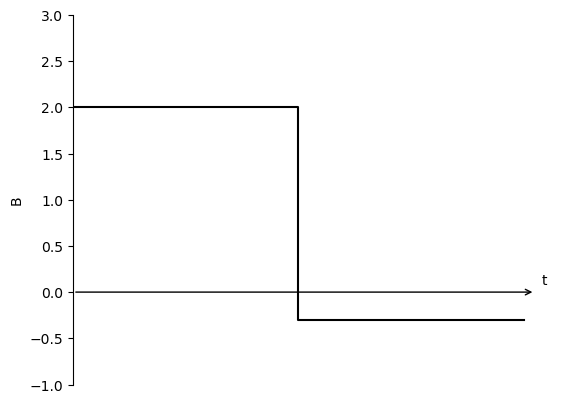

In [20]:
X = np.array([1,2,2,3])
B = np.array([2,2,-0.3,-0.3])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.xlabel("t")
plt.ylabel("B")
ax.plot(X,B,linestyle='-', color='black')
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Optional: set y-axis at x=0

ax.set_xticks([])
ax.annotate(
    '', xy=(3.05, 0), xytext=(1, 0),
    arrowprops=dict(arrowstyle='->', color='black')
)
ax.xaxis.set_label_coords(0.95, 0.3)
plt.xlim(1, 3.2)
plt.ylim(-1, 3)
plt.savefig("B_vs_t.pdf", dpi=900, bbox_inches='tight')